- research.baidu.com/Blog/index-view?id=89
- www.reddit.com/r/MachineLearning/comments/7i8yhq/r_deep_learning_scaling_is_predictable/
- supercomputersfordl2017.github.io/Presentations/scaling-is-predictable.pdf

- www.youtube.com/watch?v=XHRm3Ot5y2s
- pdfs.semanticscholar.org/e7a7/06562f313664441c54e379b04f898ee18c0e.pdf

- arthurdouillard.com/post/deep-learning-scaling/<br>
"Given the power law, researchers can train their new architecture on a small dataset, and have a good estimation of how it would scale on a bigger dataset. It may also give a reasonable estimation of the hardware and time requirements to reach a chosen generalization error."

- www.kdnuggets.com/2018/05/deep-learning-scaling-predictable-empirically.html<br>
"Finding better model architectures often depends on ‘unreliable epiphany,’ and as the results show, has limited impact compared to increasing the amount of data available. We’ve known this for some time of course, including from the 2009 Google paper, ‘The unreasonable effectiveness of data.’ The results from today’s paper help us to quantify the data advantage across a range of deep learning applications. The key to understanding is captured in the following equation:"

- **Power laws, Pareto distributions and Zipf’s law**<br>
arxiv.org/pdf/cond-mat/0412004.pdf

In [62]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
file_path = Path(os.getcwd())
file_path

PosixPath('/vol/ml/apartin/projects/pilot1/apps/lrn_crv')

In [64]:
utils_path = file_path / '../../utils'
sys.path.append(str(utils_path))
# import utils
# from lrn_crv import *
import lrn_crv

In [65]:
%matplotlib inline

In [66]:
# Results dir
maindir = file_path / '../../out/lrn_crv'

In [67]:
from scipy import optimize

def power_law_func(x, alpha, beta, gamma):
    """ docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.power.html """
    return alpha * np.power(x, beta) + gamma
    
def fit_power_law(x, y, p0: list=[30, -0.3, 0.5]):
    """ Fit learning curve data (train set size vs ) to power-law.
    TODO: How should we fit the data across multiple folds? This can
    be addressed using Bayesian methods (look at Bayesian linear regression).
    The uncertainty of parameters indicates the consistency of across folds.
    """
    prms, prms_cov = optimize.curve_fit(power_law_func, x, y, p0=p0)
    prms_dct = {}
    prms_dct['alpha'] = prms[0]
    prms_dct['beta'] = prms[1]
    prms_dct['gamma'] = prms[2]
    return prms_dct

def scale_ticks_params(tick_scale='linear'):
    """ Helper function for learning cureve plots.
    Args:
        tick_scale : available values are [linear, log2, log10]
    """
    if tick_scale == 'linear':
        base = None
        label_scale = 'Linear scale'
    else:
        if tick_scale == 'log2':
            base = 2
            label_scale = 'Log2 scale'
        elif tick_scale == 'log10':
            base = 10
            label_scale = 'Log10 scale'
        else:
            raise ValueError('The specified tick scale is not supported.')
    return base, label_scale

def plot_lrn_crv_power_law(x, y, plot_fit:bool=True, metric_name:str='score',
                           xtick_scale:str='log2', ytick_scale:str='log2',
                           xlim:list=None, ylim:list=None, title:str=None, figsize=(7,5)):
    fontsize = 13
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x, y, '.-', color=None, label='data');

    # Fit power-law
    power_law_params = fit_power_law(x, y)
    yfit = power_law_func(x, **power_law_params)
    if plot_fit: ax.plot(x, yfit, '--', color=None, label='fit');    
        
    basex, xlabel_scale = scale_ticks_params(tick_scale=xtick_scale)
    basey, ylabel_scale = scale_ticks_params(tick_scale=ytick_scale)
    
    ax.set_xlabel(f'Training Dataset Size ({xlabel_scale})', fontsize=fontsize)
    if 'log' in xlabel_scale.lower(): ax.set_xscale('log', basex=basex)

    ylabel = ' '.join(s.capitalize() for s in metric_name.split('_'))
    ax.set_ylabel(f'{ylabel} ({ylabel_scale})', fontsize=fontsize)
    if 'log' in ylabel_scale.lower(): ax.set_yscale('log', basey=basey)
        
    # ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    # Add equation (text) on the plot
    # matplotlib.org/3.1.1/gallery/text_labels_and_annotations/usetex_demo.html#sphx-glr-gallery-text-labels-and-annotations-usetex-demo-py
    # eq = r"$\varepsilon_{mae}(m) = \alpha m^{\beta} + \gamma$" + rf"; $\alpha$={power_law_params['alpha']:.2f}, $\beta$={power_law_params['beta']:.2f}, $\gamma$={power_law_params['gamma']:.2f}"
    eq = r"$\varepsilon(m) = \alpha m^{\beta}$" + rf"; $\alpha$={power_law_params['alpha']:.2f}, $\beta$={power_law_params['beta']:.2f}"
    # eq = rf"$\varepsilon(m) = {power_law_params['alpha']:.2f} m^{power_law_params['beta']:.2f} + {power_law_params['gamma']:.2f}$" # TODO: make this work
    xloc = 1.7 * x.ravel().min()
    yloc = y.ravel().min() + 1.0*(y.ravel().max()-y.ravel().min())
    ax.text(xloc, yloc, eq,
            {'color': 'black', 'fontsize': fontsize, 'ha': 'left', 'va': 'center',
             'bbox': {'boxstyle':'round', 'fc':'white', 'ec':'black', 'pad':0.2}})
    
    # matplotlib.org/users/mathtext.html
    # ax.set_title(r"$\varepsilon_{mae}(m) = \alpha m^{\beta} + \gamma$" + rf"; $\alpha$={power_law_params['alpha']:.2f}, $\beta$={power_law_params['beta']:.2f}, $\gamma$={power_law_params['gamma']:.2f}");
    if ylim is not None: ax.set_ylim(ylim)
    if xlim is not None: ax.set_ylim(xlim)
    if title is None: title='Learning curve (power-law)'
    ax.set_title(title)
    
    ax.legend(loc='best', frameon=True, fontsize=fontsize)
    ax.grid(True)
    return fig, ax, power_law_params

In [68]:
def load_scores(run_dir, metric_name='mean_absolute_error', cv_folds=5):
    """ ... """
    scores = pd.read_csv(run_dir/'lrn_crv_scores.csv')
    df = scores.loc[scores['tr_set']==False]
    
    data_sizes = sorted(df['tr_size'].unique())
    aa = df[df['metric']==metric_name].reset_index(drop=True)
    aa.sort_values('tr_size', inplace=True)

    tr = aa[aa['tr_set']==True]
    vl = aa[aa['tr_set']==False]

    tr = tr.iloc[:, -cv_folds:]
    vl = vl.iloc[:, -cv_folds:]

    rslt = []
    rslt.append(data_sizes)
    rslt.append(tr.values if tr.values.shape[0]>0 else None)
    rslt.append(vl.values if vl.values.shape[0]>0 else None)

    return rslt, scores

In [69]:
def get_xy(scores, metric_name='mean_absolute_error'):
    """ Get x and y from scores (for specific run). """
    dd = scores
    dd = dd[dd['metric']==metric_name]
    dd = dd[dd['tr_set']==False]
    dd.reset_index(drop=True, inplace=True)
    dd.drop(columns=['metric', 'tr_set'], inplace=True)
    
    x = dd.tr_size
    y = dd.iloc[:,1:].mean(axis=1)
    return x, y

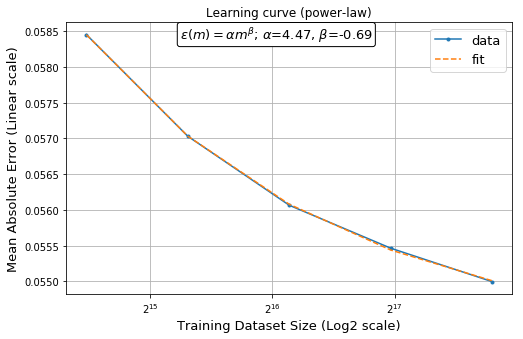

In [70]:
# rslt_dir = maindir / 'ccle.lgb_reg.cvf5.rna.dsc.AUC'
# rslt_dir = maindir / 'gdsc.lgb_reg.cvf5.rna.dsc.AUC'
# rslt_dir = maindir / 'gdsc.lgb_reg.cvf1.rna.dsc.AUC'
rslt_dir = maindir / 'topNcode.lgb_reg.cvf5.rna.dsc.AUC_2019-7-2_h15-m29'

metric_name = 'mean_absolute_error'
rslt, scores = load_scores(rslt_dir, metric_name=metric_name, cv_folds=1)
x, y = get_xy(scores, metric_name=metric_name)

fig, ax, power_law_params = plot_lrn_crv_power_law(
    x, y, plot_fit=True, metric_name=metric_name,
    xtick_scale='log2', ytick_scale='linear', figsize=(8,5));

In [71]:
x.values

array([ 22800,  40545,  72100, 128215, 228003])

In [30]:
x = x[5:]
y = y[5:]

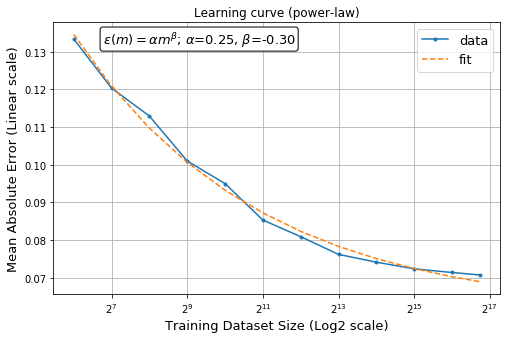

In [31]:
fig, ax, power_law_params = plot_lrn_crv_power_law(
    x, y, plot_fit=True, metric_name=metric_name,
    xtick_scale='log2', ytick_scale='linear', figsize=(8,5));

In [16]:
i = 4
rslt[0] = rslt[0][i:]
rslt[2] = rslt[2][i:]

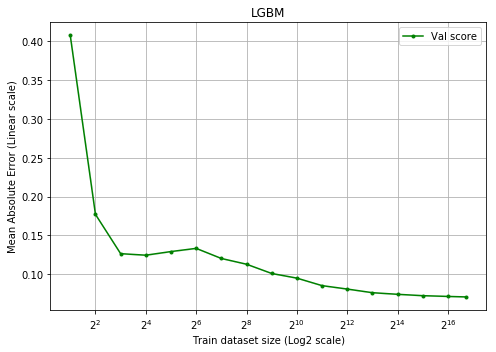

In [13]:
lrn_crv.plot_lrn_crv(rslt, metric_name=metric_name, ylim=None,
                     xtick_scale='log2', ytick_scale='linear', title='LGBM', path=None);

In [54]:
# run_dir = maindir / 'gdsc.lgb_reg.cvf5.rna.dsc.AUC_2019-7-2_h17-m37'
lgb_dir     = maindir / 'top6.lgb_reg.cvf5.rna.dsc.AUC1_2019-6-20_h15-m29'
nn_reg0_dir = maindir / 'top6.nn_model0.sgd.cvf5.rna.dsc.AUC1_2019-6-21_h23-m20'
nn_reg1_dir = maindir / 'top6.nn_model1.sgd.cvf5.rna.dsc.AUC1_2019-6-22_h22-m44'

# nn_reg0_dir = maindir / 'top6.nn_model0.clr.cvf5.rna.dsc.AUC1_2019-6-20_h16-m49'
# nn_reg1_dir = maindir / 'top6.nn_model1.clr.cvf5.rna.dsc.AUC1_2019-6-20_h16-m50'

In [55]:
metric_name = 'mean_absolute_error'
lgb_rslt,     lgb_scores     = load_scores(lgb_dir, metric_name=metric_name)
nn_reg0_rslt, nn_reg0_scores = load_scores(nn_reg0_dir, metric_name=metric_name)
nn_reg1_rslt, nn_reg1_scores = load_scores(nn_reg1_dir, metric_name=metric_name)

In [56]:
# lrn_crv.plot_lrn_crv(lgb_rslt, metric_name=metric_name, ylim=None,
#                      xtick_scale='log2', ytick_scale='linear', title='LGBM', path=None);

In [57]:
# lrn_crv.plot_lrn_crv(nn_reg0_rslt, metric_name=metric_name, ylim=None,
#                      xtick_scale='log2', ytick_scale='linear', title='nn_reg0', path=None);

In [58]:
# lrn_crv.plot_lrn_crv(nn_reg1_rslt, metric_name=metric_name, ylim=None,
#                      xtick_scale='log2', ytick_scale='linear', title='nn_reg1', path=None);

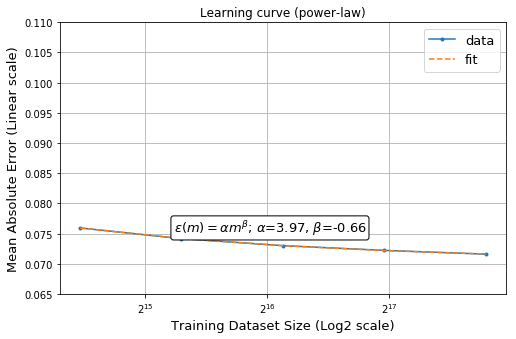

In [59]:
x, y = get_xy(lgb_scores, metric_name=metric_name)
fig, ax, power_law_params = plot_lrn_crv_power_law(x, y, plot_fit=True, metric_name=metric_name, xtick_scale='log2', ytick_scale='linear', ylim=[0.065, 0.110], figsize=(8,5));

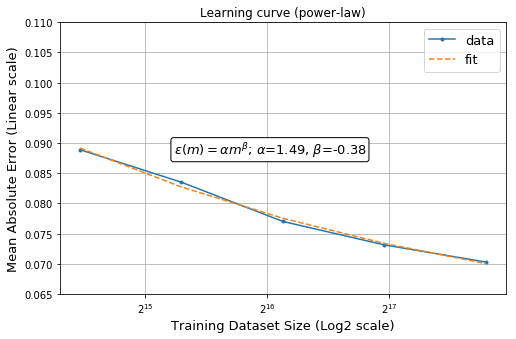

In [60]:
x, y = get_xy(nn_reg0_scores, metric_name=metric_name)
fig, ax, power_law_params = plot_lrn_crv_power_law(x, y, plot_fit=True, metric_name=metric_name, xtick_scale='log2', ytick_scale='linear', ylim=[0.065, 0.110], figsize=(8,5));

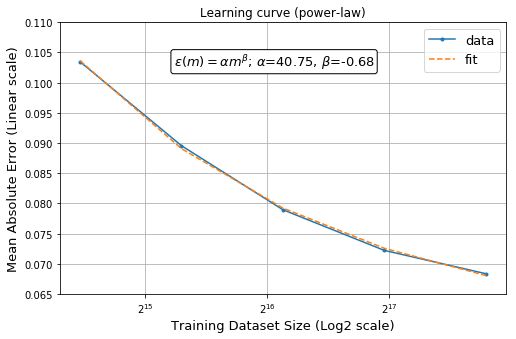

In [61]:
x, y = get_xy(nn_reg1_scores, metric_name=metric_name)
fig, ax, power_law_params = plot_lrn_crv_power_law(x, y, plot_fit=True, metric_name=metric_name, xtick_scale='log2', ytick_scale='linear', ylim=[0.065, 0.110], figsize=(8,5));

In [33]:
x = 200000
base = 2
n_shards = 5
# shard_frac_small = list(np.logspace(start=0.0, stop=1.0, num=n_shards, endpoint=True, base=base)/(x/10))
shard_frac_small = list(np.logspace(start=0.0, stop=1.0, num=n_shards, endpoint=True, base=base)/base/10)
# shard_frac_small = list(np.linspace(start=10, stop=int(0.1*x), num=n_shards, endpoint=False)/x)
print(shard_frac_small)
shard_frac = list(np.logspace(start=0.0, stop=1.0, num=n_shards, endpoint=True, base=base)/base)
print(shard_frac)
shard_frac.extend(shard_frac_small)
shard_frac = np.array( sorted(list(set(shard_frac))) )

t = x * shard_frac
print([v for v in t])

[0.05, 0.05946035575013605, 0.07071067811865475, 0.08408964152537145, 0.1]
[0.5, 0.5946035575013605, 0.7071067811865476, 0.8408964152537145, 1.0]
[10000.0, 11892.07115002721, 14142.13562373095, 16817.92830507429, 20000.0, 100000.0, 118920.7115002721, 141421.35623730952, 168179.2830507429, 200000.0]


In [31]:
t

array([1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
       1.00000000e+02, 2.00000000e+04, 3.55655882e+04, 6.32455532e+04,
       1.12468265e+05, 2.00000000e+05])

In [70]:
np.array(np.arange(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [71]:
v = 2**np.array(np.arange(20))
print(v)
idx = np.argmin( np.abs( v - x ) )
print(idx)

[     1      2      4      8     16     32     64    128    256    512
   1024   2048   4096   8192  16384  32768  65536 131072 262144 524288]
18


In [72]:
if v[idx] > x: idx -= 1
v = list(v[:idx+1])

In [73]:
v.a

[1,
 2,
 4,
 8,
 16,
 32,
 64,
 128,
 256,
 512,
 1024,
 2048,
 4096,
 8192,
 16384,
 32768,
 65536,
 131072]

In [74]:
v.append(x)
print(v)

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 200000]


In [54]:
np.min([v[idx], x])

200000

In [42]:
np.argmin(np.abs(2**np.array(np.arange(20))) - x)

0

In [39]:
2**np.array(np.arange(20))

array([     1,      2,      4,      8,     16,     32,     64,    128,
          256,    512,   1024,   2048,   4096,   8192,  16384,  32768,
        65536, 131072, 262144, 524288])

In [22]:
np.exp(np.arange(5))

array([ 1.        ,  2.71828183,  7.3890561 , 20.08553692, 54.59815003])

In [ ]:
[10, 50, 100, 150, 200, 500, 1000, 2000, 3000, 4000, 5000]

In [25]:
0.1/100*x

200.0

In [27]:
2**10

1024

# Test power plots

In [10]:
dd = scores
dd = dd[dd['metric']=='mean_absolute_error']
dd = dd[dd['tr_set']==False]
dd.reset_index(drop=True, inplace=True)
dd.drop(columns=['metric', 'tr_set'], inplace=True)

x = dd.tr_size
y = dd.f0

In [11]:
power_law_params = fit_power_law(x, y)
yfit = power_law_func(dd['tr_size'], **power_law_params)
print(power_law_params)

{'alpha': 1.0499849860718027, 'beta': -0.5016466551163483, 'gamma': 0.07002595472993757}


In [12]:
print(np.log2(x).values)
print(np.log2(y).values)

[14.46735081 15.29781188 16.1283166  16.9588019  17.78928528]
[-3.70153473 -3.73231454 -3.75999776 -3.7778145  -3.79172756]


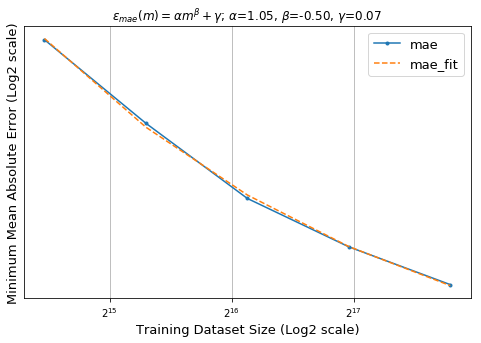

In [42]:
fig, ax, power_law_params = plot_learning_curve_power_law(x, y, plot_fit=True, xtick_scale='log2', ytick_scale='log2', figsize=(8,5));

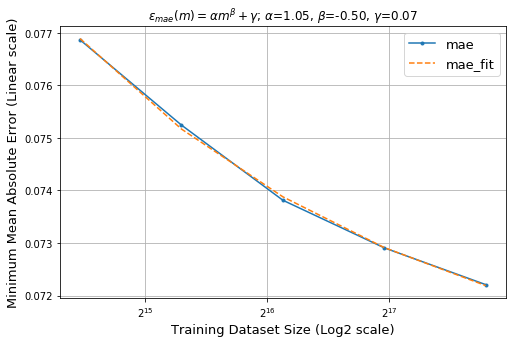

In [43]:
fig, ax, power_law_params = plot_learning_curve_power_law(x, y, plot_fit=True, xtick_scale='log2', ytick_scale='linear', figsize=(8,5));

In [32]:
# fig, ax = plt.subplots()
# ax.loglog(x, y, '.-', color='b', basex=2, basey=2);
# ax.loglog(x, yfit, '--', color='r', basex=2, basey=2);
# ax.set_xlim([2**int(np.floor(np.log2(x.values[0]))), 2**int(np.ceil(np.log2(x.values[-1])))])
# ax.set_title(r"$\varepsilon_{mae}(m) = \alpha m^{\beta} + \gamma$" + rf"; $\alpha$={power_law_params['alpha']:.2f}, $\beta$={power_law_params['beta']:.2f}, $\gamma$={power_law_params['gamma']:.2f}");
# ax.grid(True)

In [33]:
# plt.figure()
# plt.plot(np.log2(x), y, '.-', color='b');
# plt.plot(np.log2(x), yfit, '--', color='r');
# ax.set_xlim([2**int(np.floor(np.log2(x.values[0]))), 2**int(np.ceil(np.log2(x.values[-1])))])
# plt.title(r"$\varepsilon_{mae}(m) = \alpha m^{\beta} + \gamma$" + rf"; $\alpha$={power_law_params['alpha']:.2f}, $\beta$={power_law_params['beta']:.2f}, $\gamma$={power_law_params['gamma']:.2f}");
# plt.grid(True)

In [19]:
print(x.values)
print(np.log(x.values))

[ 22652  40281  71632 127382 226521]
[10.02800343 10.60363517 11.17929718 11.75494572 12.33059293]


In [20]:
np.exp(12.33059293)

226520.9989038145

In [21]:
2**int(np.floor(np.log2(x.values[0])))

16384

In [22]:
2**int(np.ceil(np.log2(x.values[-1])))

262144

In [23]:
np.log2(y)

0   -3.701535
1   -3.732315
2   -3.759998
3   -3.777814
4   -3.791728
Name: f0, dtype: float64

# Plotting learning curves on log scale

- https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
- https://stackoverflow.com/questions/14530113/set-ticks-with-logarithmic-scale
- https://stackoverflow.com/questions/21920233/matplotlib-log-scale-tick-label-number-formatting/33213196

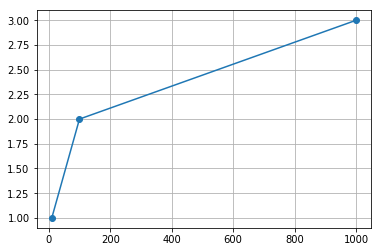

In [49]:
fig, ax = plt.subplots()
ax.plot([10, 100, 1000], [1,2,3], 'o-')
ax.set_xscale('linear')
# ax.set_xticks([10, 100, 1000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.grid(True)

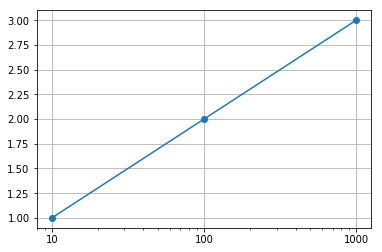

In [52]:
fig, ax = plt.subplots()
ax.plot([10, 100, 1000], [1,2,3], 'o-')
ax.set_xscale('log', basex=10)
# ax.set_xticks([10, 100, 1000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.grid(True)

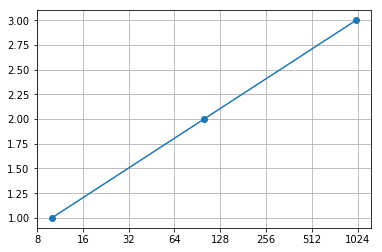

In [45]:
fig, ax = plt.subplots()
ax.plot([10, 100, 1000], [1,2,3], 'o-')
ax.set_xscale('log', basex=2)
# ax.set_xticks([10, 100, 1000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.grid(True)

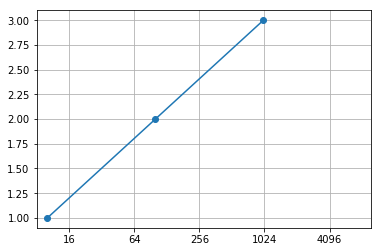

In [55]:
fig, ax = plt.subplots()
ax.plot([10, 100, 1000], [1,2,3], 'o-')
ax.set_xscale('log', basex=2)
# ax.set_xticks([20, 200, 500])
ax.set_xlim([0, 10000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.grid(True)

In [35]:
np.array([2**x for x in range(11)])

array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024])

In [30]:
fig1, ax1 = plt.subplots()
ax1.plot([10, 100, 1000], [1,2,3])
ax1.set_xscale('log')
ax1.set_xticks([20, 200, 500])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.grid(True)

0